In [47]:
import os 
import numpy as np
import open3d as o3d
import pickle as pkl 
from einops import rearrange
from utils import  *
from collections import OrderedDict
from matplotlib import pyplot as plt

### KITTI-360

In [48]:

# Congig of semantic kitti scenes(from monoScene)
scene_size = np.array((64., 64, 16))
vox_size = np.array((1, 1.,0.25))
vox_origin = np.array([0, -32, -2])


stuff_name_list = {
    # Major
    'vegetation',
    'terrain',
    'ground',
    'road', 
    'sidewalk',
    'parking',
    'rail track',
    'building',
    'gate',
    'garage', 
    'bridge',
    'tunnel',
    # Vehicle
    'wall',
    'car',
    'truck',
    'train','caravan',
    'bus',
    # Minor
    'trailer',
    'fence',
    'guard rail',
    'trash bin',
    'box',
    'lamp',
    'smallpole',
    'polegroup',
    'stop',
    'pole',
    'traffic sign',
    'traffic light'
}

H, W = 376, 1408
K = np.array([[552.554261,   0.      , 682.049453],
                 [  0.      , 552.554261, 238.769549],
                 [0., 0., 1.]])
cam_T = np.array((0,0,1.55))
cam_R = create_R((0,5 / 180 * pi,0,))
c2w = create_c2w(cam_R_world=cam_R, cam_T_world=cam_T, cam_type='opencv')
w2c = np.linalg.inv(c2w)
rays = get_rays_np(H=H, W=W, K=K, c2w=c2w, cam_type='opencv')

In [49]:
def convert_legacy_layout(layout_path):
    with open(layout_path, 'rb') as fp:
        layout_raw = pkl.load(fp)
    layout = OrderedDict()
    
    opencv2world = np.array([
            [0,0,1,0],
            [-1,0,0,0],
            [0,-1,0,0],
            [0,0,0,1]])
    for globalId,obj in layout_raw.items():
        # skip dynamic objects

        tr = np.eye(4)
        tr[:3,:3], tr[:3,3] = obj.R, obj.T
        tr = tr @ opencv2world.T

        vertices = np.concatenate((obj.vertices, np.ones_like(obj.vertices[:,0:1])), axis=-1)
        vertices = vertices @ opencv2world.T

        layout[globalId] = OrderedDict({
            'R' : tr[:3,:3],
            'T' : tr[:3,3],
            'vertices' : vertices[:,:3],
            'faces' : obj.faces,
            'name' : obj.name,
            'color' : np.array(name2label[obj.name].color),
            'semanticId' : obj.semanticId,
            'instanceId' : obj.instanceId,
            'annotationId' : obj.annotationId})
            
    return layout

def convert_legacy_stuff_semantic(semantic_voxel_path,semantic_list):
    '''
    Load old version seamntic voxel
    '''
    with open(semantic_voxel_path, 'rb') as fp:
        stuff_semantic_idx= pkl.load(fp)

    point_num = (scene_size / vox_size).astype(int) # X, Y, Z
    H, W, L = point_num[2], point_num[1], point_num[0]
    stuff_semantic = np.zeros(H * W * L)
    for s in semantic_list:
        if stuff_semantic_idx[s].shape[0] == 0:
            continue
        stuff_semantic[stuff_semantic_idx[s]] = name2label[s].id
        
    semantic_voxel = stuff_semantic.reshape(H, W, L)
    semantic_voxel = semantic_voxel.transpose(1, 2, 0) # W D H
    semantic_voxel = np.flip(semantic_voxel, axis=0)
    semantic_voxel = np.flip(semantic_voxel, axis=2)

    vertices_gridx,  vertices_gridy, vertices_gridz= np.meshgrid(np.linspace(0, scene_size[0], point_num[0]), np.linspace(0, scene_size[1], point_num[1]), np.linspace(0, scene_size[2], point_num[2]), indexing='xy') 
    loc_voxel = np.concatenate((vertices_gridx[:,:,:,None], vertices_gridy[:,:,:,None], vertices_gridz[:,:,:,None]), axis = -1)
    loc_voxel += vox_origin[None,None,None]

    return semantic_voxel, loc_voxel


In [50]:
# Load Instance Layout 
data_root = 'data/kitti-360'
frame_id = 484
legacy_layout_path = os.path.join(data_root, 'layout', '2013_05_28_drive_0000_sync', '%010d.pkl'%frame_id)
legacy_semantic_voxel_path = os.path.join(data_root, 'voxel', '2013_05_28_drive_0000_sync', '%010d.pkl'%frame_id)

semantic_voxel, loc_voxel = convert_legacy_stuff_semantic(legacy_semantic_voxel_path , stuff_name_list) # H W D 
layout = convert_legacy_layout(legacy_layout_path)
# Save all-in-one Panoptic prior ?
if False:   
    panoptic_prior_path = semantic_voxel_path = os.path.join(data_root, 'panoptic_prior', '%010d.pkl'%frame_id)
    panoptic_prior = {
        'c2w' : 0,
        'HW': (376, 1408), 
        'semantic_voxel': 0,
        'instance_layout': 0,
        'voxel_size': 0,
        'vox_origin': 0,
        'scene_size':0}


In [51]:
def vis_camera_o3d(instrinsic, extrinsic, img_size = (256,256),z_revrse = True, vis = False):
    frustums = []
    camera_size = 1
    K = np.eye(4)
    K[:3,:3] = instrinsic
    W2C = extrinsic
    C2W = np.linalg.inv(W2C)
    # img_size = (256,256)
    frustums.append(get_camera_frustum(img_size, K, W2C, frustum_length=camera_size, color=(0,0,0.)))
    # cnt += 1
    camera_group = [frustums2lineset(frustums)]
    if vis:
        o3d.visualization.draw_geometries(camera_group)

    return camera_group


def costum_visualizer_o3d(geo_group, set_camera = True, instrinsic =None, extrinsic = None, visible= False):
    vis = o3d.visualization.Visualizer()
    W = 2 * round(instrinsic[0,2] + 0.5)
    H = 2 * round(instrinsic[1,2] + 0.5)
    vis.create_window(width= W, height= H, visible= visible)
    for g in geo_group:
        vis.add_geometry(g)
    if set_camera:
        instrinsic[0,2] = W / 2 - 0.5
        instrinsic[1,2] = H / 2 - 0.5
        ctr = vis.get_view_control()
        cam = ctr.convert_to_pinhole_camera_parameters()
        cam.extrinsic = extrinsic
        cam.intrinsic.intrinsic_matrix = instrinsic
        is_su = ctr.convert_from_pinhole_camera_parameters(cam)

        cam_ = vis.get_view_control().convert_to_pinhole_camera_parameters()

    rd = vis.get_render_option()
    rd.light_on = False
    rd.background_color = np.array([0,0,0])

    # vis.update_geometry()
    vis.poll_events()
    vis.update_renderer()
    # vis.run()
    return vis


[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to

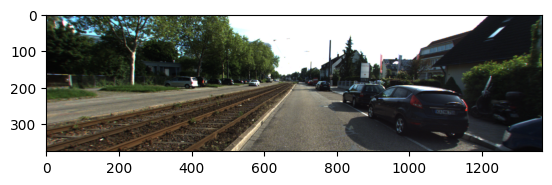

In [52]:

# Congig of semantic kitti scenes(from monoScene)
scene_size = np.array((64., 64, 16))
vox_size = np.array((1, 1.,0.25))
vox_origin = np.array([0, -32, -2])


stuff_name_list = {
    # Major
    'vegetation',
    'terrain',
    'ground',
    'road', 
    'sidewalk',
    'parking',
    'rail track',
    'building',
    'gate',
    'garage', 
    'bridge',
    'tunnel',
    # Vehicle
    'wall',
    'car',
    'truck',
    'train','caravan',
    'bus',
    # Minor
    'trailer',
    'fence',
    'guard rail',
    'trash bin',
    'box',
    'lamp',
    'smallpole',
    'polegroup',
    'stop',
    'pole',
    'traffic sign',
    'traffic light'
}

H, W = 376, 1408
K = np.array([[552.554261,   0.      , 682.049453],
                 [  0.      , 552.554261, 238.769549],
                 [0., 0., 1.]])
cam_T = np.array((0,0,1.55))
cam_R = create_R((0,5 / 180 * pi,0,))
c2w = create_c2w(cam_R_world=cam_R, cam_T_world=cam_T, cam_type='opencv')
w2c = np.linalg.inv(c2w)
rays = get_rays_np(H=H, W=W, K=K, c2w=c2w, cam_type='opencv')


# Load Instance Layout 
data_root = 'data/kitti-360'
frame_id = 7337
legacy_layout_path = os.path.join(data_root, 'layout', '2013_05_28_drive_0000_sync', '%010d.pkl'%frame_id)
legacy_semantic_voxel_path = os.path.join(data_root, 'voxel', '2013_05_28_drive_0000_sync', '%010d.pkl'%frame_id)
image_path = os.path.join(data_root, 'data_2d_raw', '2013_05_28_drive_0000_sync','image_00', '%010d.png'%frame_id)

semantic_voxel, loc_voxel = convert_legacy_stuff_semantic(legacy_semantic_voxel_path , stuff_name_list) # H W D 
layout = convert_legacy_layout(legacy_layout_path)


bounds = np.array([64, 0, 32, -32, 14, -2])
# bounds = np.array([20, 0, 5, -5, 4, -2])

geo_group = []
geo_group += vis_world_bounds_o3d(bounds=bounds)
coordinate_world = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
coordinate_cam = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1).transform(c2w)
geo_group += [coordinate_world, coordinate_cam]
geo_group += vis_voxel_world_o3d(semantic_voxel, loc_voxel, stuff_name_list)
geo_group += vis_layout_o3d(layout)
geo_group += vis_camera_o3d(instrinsic=K, extrinsic=w2c, z_revrse=True)
# o3d.visualization.draw_plotly(geo_group)
vis = costum_visualizer_o3d(geo_group=geo_group, set_camera=True, instrinsic=K, extrinsic=w2c, visible = False)
# # vis.capture_screen_image(os.path.join('tmp', '%06d'%idx + '.png'))

# vis.run()
# vis.destroy_window()
project_img = np.asarray(vis.capture_screen_float_buffer())
H_show , W_show = min(project_img.shape[0], H), min(project_img.shape[1], W)

rgb = plt.imread(image_path)
plt.imshow(project_img[:H_show,:W_show] +rgb[:H_show,:W_show])
# plt.show()
# geo_group += vis_camera_o3d(instrinsic=K, extrinsic=np.linalg.inv(c2w), z_r


In [53]:
import open3d as o3d



vis = o3d.visualization.Visualizer()
vis.create_window(width=1202, height=366, visible= True)

c = o3d.geometry.TriangleMesh.create_box()
vis.add_geometry(c)

ctr = vis.get_view_control()
cam = ctr.convert_to_pinhole_camera_parameters()
extrinsic = cam.extrinsic.copy()
extrinsic[0,3], extrinsic[1,3], extrinsic[2,3] = 10, 10, 10
cam.extrinsic = extrinsic
ctr.convert_from_pinhole_camera_parameters(cam)
# a = ctr.convert_to_pinhole_camera_parameters()
if_success = ctr.convert_from_pinhole_camera_parameters(cam)

cam_2 = vis.get_view_control().convert_to_pinhole_camera_parameters()
print('cam_1 should same as cam_2?')
print('cam_1' + str(cam.extrinsic.tolist()))
print('cam_2' + str(cam_2.extrinsic.tolist()))

# vis.run()


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
cam_1 should same as cam_2?
cam_1[[1.0, 0.0, 0.0, 10.0], [-0.0, -1.0, -0.0, 10.0], [-0.0, -0.0, -1.0, 10.0], [0.0, 0.0, 0.0, 1.0]]
cam_2[[1.0, 0.0, 0.0, 10.0], [-0.0, -1.0, -0.0, 10.0], [-0.0, -0.0, -1.0, 10.0], [0.0, 0.0, 0.0, 1.0]]


### Semantic KITTI

In [54]:
# Congig of semantic kitti scenes(from monoScene)
# scene_size = np.array((51.2, 51.2, 6.4))
# voxel_size = np.array((0.2,0.2,0.2))
# vox_origin = np.array([0, -25.6, -2])

In [55]:
# Load scene semantic pred from monoscene
# data_root = 'data/semantic-kitti'
# image_dir = os.path.join(data_root, 'image_2')
# voxel_dir = os.path.join(data_root, 'voxel')

In [56]:
# Scene Semantic Voxel
# v_locx, v_locy, v_locz = np.meshgrid((np.linspace(0, scene_size[0],voxel_size[0]), np.linspace(0, scene_size[1],voxel_size[1]), np.linspace(0, scene_size[2],voxel_size[2])))
# v_loc_grid = np.concatenate((v_locx,v_locy,v_locz)) + vox_origin[None,None,None]

In [57]:
# Cerate camera


### Clevr-W

### Waymo (TODO)
### NuScene (TODO)